In [41]:
# Imports
import sys
sys.executable
import numpy as np
import requests # for downloading webpages
from bs4 import BeautifulSoup  # for parsing HTML
import pandas as pd # for storing and handling datasets
import time # for adding delays between requests
from selenium import webdriver
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By


In [42]:
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px


Business and Customer Use Cases for the Sustainability Scoring System:

The sustainability scoring system provides a unified and transparent method for evaluating the environmental and ethical performance of apparel products. By integrating Life Cycle Assessment (LCA) based data, origin impact factors, care-phase impacts, and certification bonuses, the system produces a clear Sustainability Score (0–100) for each product. This score benefits both business stakeholders and end customers by addressing key challenges related to transparency, decision-making, and regulatory compliance.
In addition, this project investigates whether the sustainability characteristics of fashion products—measured through materials, certifications, origin, and care impact—are correlated with retail price. The aim is to explore whether more sustainable materials consistently lead to higher prices, or whether identifiable pricing patterns emerge across different brands and product categories.

Sustainability Scoring Pipeline — Full Workflow

Phase 0 — Raw Data
Raw Datasets (Product Data + Reference Tables)


Phase 1 — Statistical Scoring Model
Cleaning & Standardization (Product Data Only)
    • Fix material names
    • Standardize certifications
    • Clean origins, categories, percentages
    • Remove duplicates and formatting noise
    
Merge Reference Tables
    • Merge Material LCA table
    • Merge Origin impact table
    • Merge Care Instruction impact table
    • Merge Certification bonus table

Final Sustainability Score (0–100)
    • Weighted statistical scoring model:
      Final_Score = f(Material, Origin, Care, Certification)
    

Phase 2 — Machine Learning Model Price Prediction given the features.
ML- Preparing the Data for Machine Learning
    • X = normalized features (Material_Score, Origin_Score, Care_Score, Certification bonus, etc.)
    • y = Final price

Machine Learning Model Training
    • Regression → Predict price given the sustainability score
    • Clustering → Group similar products

Phase 3 — Web Scoring System or/+ price predict (Optional)
User provides Product URL or type product information
Web API Extracts Product Info
    • Scrapes product page (materials, origin, care, certifications)
    • Cleans and standardizes extracted data



In [43]:
# product dataset
df_original= pd.read_csv("FashionProductsDataset_Original.csv")   
df_original.head()

,Id,Product_Name,Price,Material,Percentage_Material,Certification1,Certification2,Shop_Name,Category,Subcategory,Origin,Care_Instruction
0,1,Jacquard-knit merino wool jumper,€ 79.99,Wool,100.0,RWS,NaN,H&M,Woman,Jumper,China,Hand wash
1,2,Oversize Jumper,€ 24.99,Polyester,50.0,NaN,NaN,H&M,Woman,Jumper,China,Machine wash 30°C
2,2,Oversize Jumper,€ 24.99,Polyamide,29.0,NaN,NaN,H&M,Woman,Jumper,China,Machine wash 30°C
3,2,Oversize Jumper,€ 24.99,Acrylic,13.0,NaN,NaN,H&M,Woman,Jumper,China,Machine wash 30°C
4,2,Oversize Jumper,€ 24.99,Wool,5.0,NaN,NaN,H&M,Woman,Jumper,China,Machine wash 30°C



PRODUCT DATASET COLUMN DESCRIPTIONS:

Id: Unique product identifier. Multi-material products repeat the same Id across multiple rows (one row per material component).

Product_Name: Descriptive fashion product name 

Price: Retail selling price in Euros (€)

Material: The fibre used for the product (blend fiber - one per row)

Percentage_Material: Percentage of the product made from this material.

Certificate1: Primary sustainability certification linked to the material, Otherwise NaN).
 
Certificate2: Secondary certification. Otherwise "N/A".

Shop_Name: Brand associated with the product (H&M, Zara, Penneys, Patagonia).

Category: Gender classification of the product ("Woman" or "Man").

Subcategory: Product type classification. One of: "Tshirt", "Jumper", "Sweater", "Jacket".

Origin: Country of manufacture.

Care_Instruction: Washing/maintenance guidance based on material.


DATA PREPROCESSING 1:

In [44]:
# size of product dataset
df_original.shape

(1488, 12)

In [45]:
# data types
df_original.dtypes

Id                       int64
Product_Name            object
Price                   object
Material                object
Percentage_Material    float64
Certification1          object
Certification2          object
Shop_Name               object
Category                object
Subcategory             object
Origin                  object
Care_Instruction        object
dtype: object

In [46]:
# product dataset info
df_original.info # NaN values in Certification is not missing value, is the because there is no Certificate

<bound method DataFrame.info of         Id                      Product_Name     Price   Material  \
0        1  Jacquard-knit merino wool jumper   € 79.99       Wool   
1        2                   Oversize Jumper   € 24.99  Polyester   
2        2                   Oversize Jumper   € 24.99  Polyamide   
3        2                   Oversize Jumper   € 24.99    Acrylic   
4        2                   Oversize Jumper   € 24.99       Wool   
...    ...                               ...       ...        ...   
1483  1003                   Jumper Textured  € 113.09       Wool   
1484  1004                 Jumper Asymmetric  € 108.94    Acrylic   
1485  1004                 Jumper Asymmetric  € 108.94     Cotton   
1486  1005                     Jumper Ribbed  € 224.17   Cashmere   
1487  1006                  Jacket Oversized   € 27.97    Acrylic   

      Percentage_Material Certification1 Certification2  Shop_Name Category  \
0                   100.0            RWS            NaN     

In [47]:
# print unique values of product Dataset
# Unique values in Certification1
unique_cert1 = df_original["Certification1"].unique()
print("Unique Certification1 values:")
print(unique_cert1)

# Unique values in Certification2
unique_cert2 = df_original["Certification2"].unique()
print("\nUnique Certification2 values:")
print(unique_cert2)

# Unique materials
unique_materials = df_original["Material"].unique()
print("\nUnique Material values:")
print(unique_materials)

# Unique Origen
unique_origin = df_original["Origin"].unique()
print("\nUnique Origin values:")
print(unique_origin)

# Unique SubCategory
unique_sub= df_original["Subcategory"].unique()
print("\nUnique Subcategory values:")
print(unique_sub)

# Unique category
unique_sub= df_original["Category"].unique()
print("\nUnique Category values:")
print(unique_sub)

# Unique Shop_Name
unique_name= df_original["Shop_Name"].unique()
print("\nUnique Shop_Name values:")
print(unique_name)

# Care Instruction
unique_inst= df_original["Care_Instruction"].unique()
print("\nUnique Instruction values:")
print(unique_inst)

Unique Certification1 values:
[' RWS' nan 'RWS' 'Fair Trade ' 'Bluesign' 'Oeko-Tex 100' 'Fair Trade'
 'GRS' 'BCI Cotton']

Unique Certification2 values:
[nan ' RCS' 'Fair Trade ' 'Bluesign']

Unique Material values:
['Wool' 'Polyester' 'Polyamide' 'Acrylic' 'Elastane' 'wool'
 'Recycled Polyester' 'Recycled Acrylic' 'Cashmere' 'Recycled Wool'
 'Recycled Nylon' 'Lyocell' 'Cotton' 'Recycled Cashmere' 'Viscose'
 'Organic Cotton' 'Merino Wool' 'Recycled Cotton' 'Nylon']

Unique Origin values:
['China' 'Cambodia' 'Vietnam' 'Thailand' 'Turkey' 'Portugal' 'Bangladesh'
 'India' 'Italy']

Unique Subcategory values:
['Jumper' 'sweater' 'Tshirt' 'Jacket' 'Sweater']

Unique Category values:
['Woman' "Woman's Knitwear" 'Man']

Unique Shop_Name values:
['H&M' 'Zara' 'Patagonia' 'Penneys']

Unique Instruction values:
['Hand wash' 'Machine wash 30°C']


In [48]:
# Clean unique values - Standardize with Reference tables

df_clean = df_original.copy() # copy df_original to clean (df_clean)


# Clean Certification1
df_clean["Certification1"] = (
    df_clean["Certification1"]
    .replace({
        " RWS": "RWS",
        "RWS ": "RWS",
        "Fair Trade ": "Fair Trade",
        " Fair Trade ": "Fair Trade"
    })
)

# Clean Certification2
df_clean["Certification2"] = (
    df_clean["Certification2"]
    .replace({
        " RCS": "RCS",
        "RCS ": "RCS",
        "Fair Trade ": "Fair Trade",
        " Fair Trade ": "Fair Trade"
    })
)

# Clean Material
df_clean["Material"] = (
    df_clean["Material"]
    .replace({
        "wool": "Wool"
        })
)
          


In [49]:
# clean Category to woman
df_clean["Category"] = df_clean["Category"].replace({
    "Woman's Knitwear": "Woman"
})

In [50]:
# removing space if any
df_clean["Category"] = df_clean["Category"].str.strip()

In [52]:
# removing space of subcategory if any
df_clean["Subcategory"] = df_clean["Subcategory"].str.strip().str.title()


In [51]:
# verify changes in unique values of category and subcategory
print(df_clean["Category"].unique())
print(df_clean["Subcategory"].unique())


['Woman' 'Man']
['Jumper' 'sweater' 'Tshirt' 'Jacket' 'Sweater']


In [53]:
# verify changes in Unique Value
# Unique values in Certification1
unique_cert1 = df_clean["Certification1"].unique()
print("Unique Certification1 values:")
print(unique_cert1)

# Unique values in Certification2
unique_cert2 = df_clean["Certification2"].unique()
print("\nUnique Certification2 values:")
print(unique_cert2)

# Unique materials
unique_materials = df_clean["Material"].unique()
print("\nUnique Material values:")
print(unique_materials)

Unique Certification1 values:
['RWS' nan 'Fair Trade' 'Bluesign' 'Oeko-Tex 100' 'GRS' 'BCI Cotton']

Unique Certification2 values:
[nan 'RCS' 'Fair Trade' 'Bluesign']

Unique Material values:
['Wool' 'Polyester' 'Polyamide' 'Acrylic' 'Elastane' 'Recycled Polyester'
 'Recycled Acrylic' 'Cashmere' 'Recycled Wool' 'Recycled Nylon' 'Lyocell'
 'Cotton' 'Recycled Cashmere' 'Viscose' 'Organic Cotton' 'Merino Wool'
 'Recycled Cotton' 'Nylon']


In [54]:
# Material Reference table (based on LCA and Higg MSI data):
df_material= pd.read_csv("Material_Reference.csv")   
df_material

,Material,Category,Carbon_kgCO2e,Water_L,FossilEnergy_MJ,ChemicalImpact_Score,Notes
0,Cotton,Natural,6.0,2700,55,40,High water & pesticide use
1,Organic Cotton,Natural,3.2,1800,40,20,No synthetic pesticides
2,Recycled Cotton,Recycled,2.0,500,20,10,Lower energy/water use
3,Polyester,Synthetic,9.5,50,120,35,Fossil-fuel based
4,Recycled Polyester,Recycled,5.5,20,60,20,Uses post-consumer PET
5,Acrylic,Synthetic,6.0,30,110,40,"Fossil-based, similar to nylon impact"
6,Recycled Acrylic,Recycled,3.5,15,55,20,Reduced energy & waste
7,Wool,Natural,14.0,800,160,45,Methane emissions from sheep
8,Merino Wool,Natural,16.0,900,170,48,Higher land/methane impact
9,Cashmere,Natural,30.0,700,200,60,Very high impact (land & methane)


Material Impact Reference Table:
Carbon footprint: kg CO₂e / kg material
Water consumption: litres / kg
Fossil fuel energy: MJ / kg
Chemical impact: relative score (Higg MSI uses weighted scoring)
Need to Normalize for the score system.
NOTE: These are representative values based on Higg MSI published numbers + LCA averages. They are suitable for early modelling.

In [55]:
# Certification Reference table:
df_cert= pd.read_csv("Certification,_Reference.csv")   
df_cert

,Certification,Category,Score_Bonus,Description
0,GOTS,Environmental+Social,0.25,"Organic fibre, chemical safety, full supply ch..."
1,GRS,Recycled+Traceability,0.20,"Verifies recycled content, chemical restrictio..."
2,RWS,Animal Welfare,0.15,"Responsible Wool Standard, land and animal man..."
3,RDS,Animal Welfare,0.15,Responsible Down Standard
4,Fair Trade,Social,0.20,Improved labour conditions and community devel...
5,Oeko-Tex 100,Chemical Safety,0.10,Harmful substance testing only
6,Bluesign,Chemical Safety+Process,0.20,"Controlled chemical inputs, cleaner production"
7,BCI Cotton,Environmental,0.05,"Basic improvement programme, low traceability"
8,NaN,NaN,0.00,No sustainability certification
9,RCS,Recycled,0.10,Recycled Claim Standard (verifies recycled con...


Certification score bonuses reflect the relative strength, scope, and verification rigor of sustainability standards applied to a product. Because certifications do not provide direct LCA measurements, they are incorporated through weighted bonus values (Normalized Values 0-1) that represent their ability to reduce environmental and social risk. Stronger certifications such as Bluesign, GRS, and Fair Trade receive higher bonuses due to their robust criteria and auditing systems, whereas lighter standards like Oeko-Tex 100 or BCI Cotton receive smaller bonuses. Products without certifications receive no bonus. this system of adding Bonus is Higg-based scoring systems.

In [56]:
# Origin Reference table:
df_origin= pd.read_csv("Origin_Reference.csv")   
df_origin

,Origin,Energy_Grid_Intensity,Transport_Impact_Score,Manufacturing_Impact_Score,Notes
0,China,0.65,0.40,0.60,Coal-heavy grid; large-scale manufacturing; lo...
1,Bangladesh,0.55,0.45,0.70,Developing grid; high garment production volum...
2,India,0.50,0.40,0.65,Coal + renewables; textile-intensive industry;...
3,Vietnam,0.45,0.35,0.55,Balanced grid; strong apparel export sector; l...
4,Turkey,0.40,0.20,0.45,Closer to EU market; medium-impact grid; stron...
5,Portugal,0.25,0.10,0.30,Low-carbon EU grid; short transport; higher ma...
6,Italy,0.30,0.10,0.35,High-quality manufacturing; short transport di...
7,Cambodia,0.55,0.45,0.75,Developing grid; high reliance on imported ele...
8,Thailand,0.45,0.35,0.55,Mid-impact energy grid; established apparel in...


The Origin Impact Table models the environmental burden of producing a garment in different countries using three normalized indicators: energy grid intensity, transport distance, and manufacturing efficiency. These values are not percentages but relative impact indices (0–1 range) used to compare countries. This method follows LCA logic and Higg MSI principles when detailed country-specific emissions data is unavailable. The indices are later combined to calculate an Origin Sustainability Score for each product.those number are impact indices based on Higg Facility Environmental Module (FEM), Academic LCA gap-filling, EU PEF models when detailed data is missing. Any sustainability scoring when manufacturing detail is unknown.

| **Index Value** | **Impact Level**     | **Meaning / Interpretation**                                                        |
| --------------- | -------------------- | ----------------------------------------------------------------------------------- |
| **0.00 – 0.10** | **Very Low Impact**  | Clean energy grid, very efficient manufacturing, short transport distance.          |
| **0.11 – 0.25** | **Low Impact**       | Mostly renewable energy, moderate manufacturing efficiency, short/medium transport. |
| **0.26 – 0.45** | **Moderate Impact**  | Mixed energy grid, average factory efficiency, long-distance transport.             |
| **0.46 – 0.60** | **High Impact**      | Fossil-fuel heavy grid, lower manufacturing efficiency, long ocean freight routes.  |
| **0.61 – 1.00** | **Very High Impact** | Coal-dominated grids, weak environmental controls, long-distance logistics.         |


In [57]:
# Care_Instruction Reference table:
df_care= pd.read_csv("Care_Instruction_Reference.csv")   
df_care

,Care_Instruction,Energy_Use_MJ,Water_Use_L,CO2_kg,Notes
0,Machine wash 30°C,0.5,15.0,0.040,Low temperature reduces energy demand by ~40%;...
1,Machine wash 40°C,0.8,15.0,0.070,Medium energy demand; standard wash cycle; mod...
2,Machine wash cold,0.3,15.0,0.020,Lowest energy use; often recommended for delic...
3,Hand wash,0.2,8.0,0.015,Lower mechanical energy but higher labor; used...
4,Machine wash 30°C + tumble dry,2.5,15.0,0.200,Tumble drying significantly increases total en...
5,Machine wash 30°C + line dry,0.5,15.0,0.040,Line drying avoids high energy use; lowest-imp...
6,Dry clean,3.5,0.5,0.250,High chemical and energy impact; typically for...


the Care Instruction Reference Table contains raw quantitative environmental impact values describing the consumer-use phase of a garment’s life cycle. These values come from LCA literature and represent the estimated resource consumption associated with typical washing and drying practices.Care-phase impacts depend on consumer behavior, home energy mix, and the number of washes—data that is typically unavailable. For consistency with the Origin and Certification components, the care-phase impact is represented using a normalized Care Score (0–1), where higher values indicate lower environmental burden. This approach is widely used in multi-criteria sustainability assessments when detailed consumption-phase LCA data cannot be obtained.

MERGE PRODUCT DATA WITH REFERENCE TABLES IN ONE DATASET:

In [58]:
# make a working copy
df_merged = df_clean.copy()

# Merge Material Table
df_merged = df_merged.merge(
    df_material[['Material','Carbon_kgCO2e','Water_L','FossilEnergy_MJ','ChemicalImpact_Score']],
    how='left',
    on='Material'
)

# Merge Care Table
df_merged = df_merged.merge(
    df_care[['Care_Instruction','Energy_Use_MJ','Water_Use_L','CO2_kg']],
    how='left',
    on='Care_Instruction'
)

# Merge Origin Table
df_merged = df_merged.merge(
    df_origin[['Origin','Energy_Grid_Intensity','Transport_Impact_Score','Manufacturing_Impact_Score']],
    how='left',
    on='Origin'
)

# Certification Bonus Table
cert_bonus = df_cert[['Certification', 'Score_Bonus']]

# Merge Certification 1 Bonus
df_merged = df_merged.merge(
    cert_bonus.rename(columns={'Score_Bonus': 'Cert1_Bonus'}),
    how='left',
    left_on='Certification1',
    right_on='Certification'
).drop(columns=['Certification'])

# Merge Certification 2 Bonus
df_merged = df_merged.merge(
    cert_bonus.rename(columns={'Score_Bonus': 'Cert2_Bonus'}),
    how='left',
    left_on='Certification2',
    right_on='Certification'
).drop(columns=['Certification'])


In [59]:
df_merged


,Id,Product_Name,Price,Material,Percentage_Material,Certification1,Certification2,Shop_Name,Category,Subcategory,...,FossilEnergy_MJ,ChemicalImpact_Score,Energy_Use_MJ,Water_Use_L,CO2_kg,Energy_Grid_Intensity,Transport_Impact_Score,Manufacturing_Impact_Score,Cert1_Bonus,Cert2_Bonus
0,1,Jacquard-knit merino wool jumper,€ 79.99,Wool,100.0,RWS,NaN,H&M,Woman,Jumper,...,160.0,45.0,0.2,8.0,0.015,0.65,0.40,0.60,0.15,0.0
1,2,Oversize Jumper,€ 24.99,Polyester,50.0,NaN,NaN,H&M,Woman,Jumper,...,120.0,35.0,0.5,15.0,0.040,0.65,0.40,0.60,0.00,0.0
2,2,Oversize Jumper,€ 24.99,Polyamide,29.0,NaN,NaN,H&M,Woman,Jumper,...,NaN,NaN,0.5,15.0,0.040,0.65,0.40,0.60,0.00,0.0
3,2,Oversize Jumper,€ 24.99,Acrylic,13.0,NaN,NaN,H&M,Woman,Jumper,...,110.0,40.0,0.5,15.0,0.040,0.65,0.40,0.60,0.00,0.0
4,2,Oversize Jumper,€ 24.99,Wool,5.0,NaN,NaN,H&M,Woman,Jumper,...,160.0,45.0,0.5,15.0,0.040,0.65,0.40,0.60,0.00,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1483,1003,Jumper Textured,€ 113.09,Wool,100.0,Fair Trade,Bluesign,Patagonia,Man,Jumper,...,160.0,45.0,0.2,8.0,0.015,0.65,0.40,0.60,0.20,0.2
1484,1004,Jumper Asymmetric,€ 108.94,Acrylic,46.4,Fair Trade,Bluesign,Patagonia,Man,Jumper,...,110.0,40.0,0.5,15.0,0.040,0.25,0.10,0.30,0.20,0.2
1485,1004,Jumper Asymmetric,€ 108.94,Cotton,53.6,Fair Trade,Bluesign,Patagonia,Man,Jumper,...,55.0,40.0,0.5,15.0,0.040,0.25,0.10,0.30,0.20,0.2
1486,1005,Jumper Ribbed,€ 224.17,Cashmere,100.0,Fair Trade,Bluesign,Patagonia,Woman,Jumper,...,200.0,60.0,0.2,8.0,0.015,0.40,0.20,0.45,0.20,0.2


In [60]:
# rename columns
df_merged = df_merged.rename(columns={

    # material impact
    "Carbon_kgCO2e": "Material_CO2",
    "Water_L": "Material_Water",
    "FossilEnergy_MJ": "Material_Energy",
    "ChemicalImpact_Score": "Material_Chemical",

    # care impact
    "Energy_Use_MJ": "Care_Energy",
    "Water_Use_L": "Care_Water",
    "CO2_kg": "Care_CO2",

    # origin impact
    "Energy_Grid_Intensity": "Origin_Grid",
    "Transport_Impact_Score": "Origin_Transport",
    "Manufacturing_Impact_Score": "Origin_Manufacturing",
    
    # certification name rename
    "Certification1": "Certificate1",
    "Certification2": "Certificate2",
    
    # certification name rename
    "Shop_Name":"Brand"
    
    
})

   


In [61]:
# reorder
ordered_cols = [

    # PRODUCT IDENTIFICATION
    "Id", "Brand", "Product_Name", "Price",

    # CATEGORY INFO
    "Category", "Subcategory",

    # MATERIAL DATA
    "Material", "Percentage_Material",
    "Material_CO2", "Material_Water", "Material_Energy", "Material_Chemical",

    # CARE INSTRUCTION DATA
    "Care_Instruction",
    "Care_CO2", "Care_Energy", "Care_Water",

    # ORIGIN DATA
    "Origin",
    "Origin_Grid", "Origin_Transport", "Origin_Manufacturing",

    # CERTIFICATIONS
    "Certificate1", "Cert1_Bonus",
    "Certificate2", "Cert2_Bonus"
]

# APPLY REORDER (keeping any extra columns at the end)
df_merged = df_merged[ordered_cols + 
                      [c for c in df_merged.columns if c not in ordered_cols]]


In [62]:
# check columns names
print(list(df_merged.columns))


['Id', 'Brand', 'Product_Name', 'Price', 'Category', 'Subcategory', 'Material', 'Percentage_Material', 'Material_CO2', 'Material_Water', 'Material_Energy', 'Material_Chemical', 'Care_Instruction', 'Care_CO2', 'Care_Energy', 'Care_Water', 'Origin', 'Origin_Grid', 'Origin_Transport', 'Origin_Manufacturing', 'Certificate1', 'Cert1_Bonus', 'Certificate2', 'Cert2_Bonus']


DATA QUALITY AND FIRST EDA (EXPLORATORY DATA ANALYSIS):

In [63]:
# check duplicates
df_merged.duplicated().sum()


np.int64(0)

In [64]:
# check nan values
df_merged.isna().sum().sort_values(ascending=False)


Certificate2            1199
Certificate1             736
Material_Water             2
Material_CO2               2
Material_Chemical          2
Material_Energy            2
Id                         0
Brand                      0
Percentage_Material        0
Material                   0
Subcategory                0
Category                   0
Price                      0
Product_Name               0
Care_Instruction           0
Care_CO2                   0
Care_Water                 0
Care_Energy                0
Origin                     0
Origin_Grid                0
Origin_Manufacturing       0
Origin_Transport           0
Cert1_Bonus                0
Cert2_Bonus                0
dtype: int64

Missing certification values were interpreted as the absence of sustainability certifications rather than data errors

In [65]:
# droping 2 rows of nan values in material
df_merged = df_merged.dropna(
    subset=[
        "Material_CO2",
        "Material_Water",
        "Material_Energy",
        "Material_Chemical"
    ]
)


In [66]:
# material distribution
df_merged["Material"].value_counts()


Material
Recycled Polyester    176
Organic Cotton        173
Cotton                159
Acrylic               128
Elastane              105
Wool                  103
Polyester              89
Recycled Acrylic       89
Recycled Cashmere      74
Cashmere               72
Merino Wool            71
Lyocell                62
Nylon                  58
Recycled Cotton        50
Recycled Nylon         48
Viscose                29
Name: count, dtype: int64

The dataset shows strong representation of recycled fibres, particularly recycled polyester, reflecting current industry transitions toward circular material strategies. under representation of recycled wool and polyamide.not dominated by luxury fibres.If cashmere were 400 rows, your prices would skew high, So this is a very healthy structure for price modelling.

In [67]:
# create a clean numeric price column
df_merged["Price_num"] = (
    df_merged["Price"].astype(str)
    .str.replace("€", "", regex=False)
    .str.strip()
)
# change price data type to numeric (float)
df_merged["Price_num"] = pd.to_numeric(df_merged["Price_num"], errors="coerce")

# check it worked
print(df_merged["Price"].dtype, "->", df_merged["Price_num"].dtype)
print("Missing Price_num:", df_merged["Price_num"].isna().sum())


object -> float64
Missing Price_num: 0


In [68]:
# product price by material
material_price = (
    df_merged
    .groupby("Material")["Price_num"]
    .mean()
    .sort_values()
)



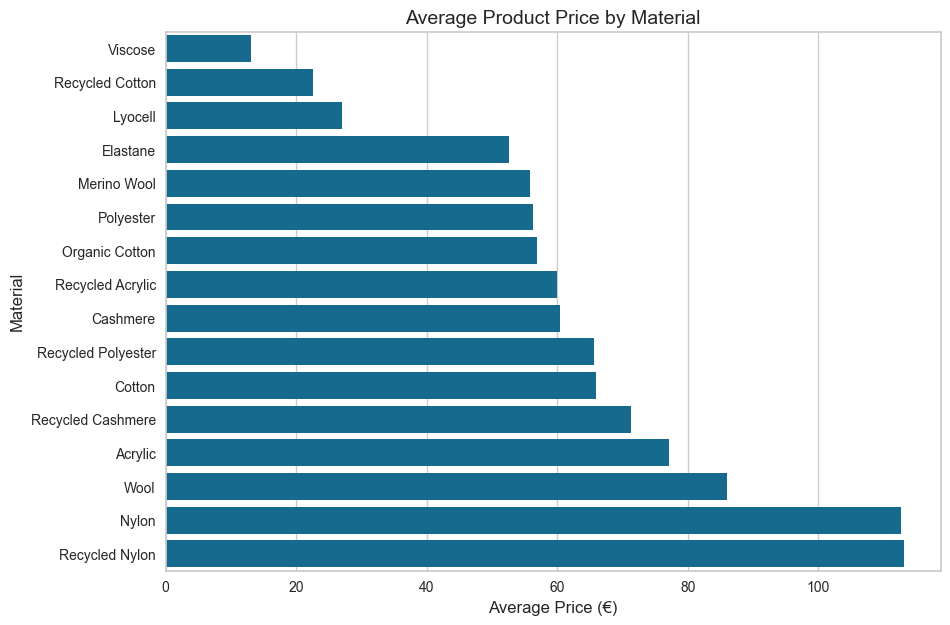

In [69]:
plt.figure(figsize=(10,7))

sns.barplot(
    x=material_price.values,
    y=material_price.index
)

plt.title("Average Product Price by Material", fontsize=14)
plt.xlabel("Average Price (€)", fontsize=12)
plt.ylabel("Material", fontsize=12)

plt.show()


Some materials exhibit extreme average prices due to low sample representation and should therefore be interpreted with caution. Price variation across materials aligns with expected market patterns but not only fiber influence price.

In [70]:
# country distribution
df_merged["Origin"].value_counts()


Origin
Cambodia      185
Italy         183
Portugal      177
Turkey        175
Bangladesh    168
Thailand      165
China         157
Vietnam       142
India         134
Name: count, dtype: int64

In [71]:
# check porcentage of all material is 100%
df_merged.groupby("Id")["Percentage_Material"].sum().describe()


count    1006.000000
mean       99.897416
std         2.505094
min        26.000000
25%       100.000000
50%       100.000000
75%       100.000000
max       100.100000
Name: Percentage_Material, dtype: float64

In [72]:
# count of each certificate1
df_merged["Certificate1"].value_counts(dropna=False)


Certificate1
NaN             735
Fair Trade      396
Oeko-Tex 100    201
RWS              72
GRS              59
BCI Cotton       22
Bluesign          1
Name: count, dtype: int64

In [73]:
# count of each certificate2
df_merged["Certificate2"].value_counts(dropna=False)

Certificate2
NaN           1197
Bluesign       284
RCS              4
Fair Trade       1
Name: count, dtype: int64

In [74]:
# save df_merged
df_merged.to_csv("Merged_product_dataset.csv", index=False)
